In [8]:
# Rendu final – Approches quantitatives et modélisation mathématique
# Titre du projet : Évolution thématique de la presse française (1950–1970): une approche quantitative et diachronique
# Susanna De Luca – Master 2 Humanités Numériques – Janvier 2026


In [9]:
# 1) Chargement du corpus en mode streaming (rapide et léger)
# Le dataset complet est très volumineux. Le mode "streaming" permet
# de lire les données progressivement, sans tout télécharger ni saturer la RAM.

!pip install -q datasets

from datasets import load_dataset

ds_stream = load_dataset("PleIAs/French-PD-Newspapers", split="train", streaming=True)

# Test rapide : on récupère 1 exemple pour vérifier les champs disponibles
ex = next(iter(ds_stream))
print(ex.keys())


Resolving data files:   0%|          | 0/320 [00:00<?, ?it/s]

dict_keys(['file_id', 'ocr', 'title', 'date', 'author', 'page_count', 'word_count', 'character_count', 'complete_text'])


In [10]:
# 2) Construction d’un sous-corpus équilibré (1950s / 1960s / 1970s)
# Principe :
# - On lit le dataset en streaming (sans télécharger tout le corpus).
# - On extrait l'année (robuste) depuis la chaîne "date" grâce à une regex.
# - On remplit des quotas par décennie (100 + 100 + 100).
# - On stocke immédiatement "annee" et "decennie" dans chaque enregistrement.

import re
import time
import pandas as pd

def extraire_annee(valeur):
    """Extrait une année (4 chiffres) depuis une chaîne, sinon None."""
    if valeur is None:
        return None
    m = re.search(r"(18|19|20)\d{2}", str(valeur))
    return int(m.group(0)) if m else None

quotas = {
    "1950s": {"min": 1950, "max": 1959, "target": 100, "count": 0},
    "1960s": {"min": 1960, "max": 1969, "target": 100, "count": 0},
    "1970s": {"min": 1970, "max": 1979, "target": 100, "count": 0},
}

selection = []
lus = 0

it = iter(ds_stream)

while True:
    try:
        ex = next(it)
        lus += 1

        annee = extraire_annee(ex.get("date", None))
        if annee is None:
            continue

        # Remplissage des quotas
        for decade, cfg in quotas.items():
            if cfg["min"] <= annee <= cfg["max"] and cfg["count"] < cfg["target"]:
                ex2 = dict(ex)  # copie
                ex2["annee"] = annee
                ex2["decennie"] = decade
                selection.append(ex2)
                cfg["count"] += 1
                break

        # Suivi léger
        if lus % 5000 == 0:
            print("Lus :", lus, "| Sélection :", len(selection),
                  "| Quotas :", {k: v["count"] for k, v in quotas.items()})

        # Arrêt
        if all(cfg["count"] >= cfg["target"] for cfg in quotas.values()):
            break

    except StopIteration:
        break
    except Exception as e:
        # En cas de micro-coupure réseau, on attend puis on continue
        print("Avertissement (réseau/lecture) :", repr(e))
        time.sleep(2)
        continue

df = pd.DataFrame(selection)

print("Taille du corpus :", len(df))
print("Répartition par décennie :")
print(df["decennie"].value_counts().sort_index())

df[["date", "annee", "decennie", "title", "word_count"]].head(5)


Lus : 5000 | Sélection : 69 | Quotas : {'1950s': 29, '1960s': 20, '1970s': 20}
Lus : 10000 | Sélection : 152 | Quotas : {'1950s': 53, '1960s': 48, '1970s': 51}
Lus : 15000 | Sélection : 222 | Quotas : {'1950s': 88, '1960s': 62, '1970s': 72}
Lus : 20000 | Sélection : 283 | Quotas : {'1950s': 100, '1960s': 91, '1970s': 92}
Taille du corpus : 300
Répartition par décennie :
decennie
1950s    100
1960s    100
1970s    100
Name: count, dtype: int64


,date,annee,decennie,title,word_count
0,1952-11-01,1952,1950s,Aviation magazine,27805
1,1969-08-15,1969,1960s,France-aviation,21045
2,1957-12-15,1957,1950s,Les Jeunes : courrier de quinzaine du journal ...,9344
3,1950-09-05,1950,1950s,La Croix du Nord : supplément régional à la Cr...,35193
4,1959-03-17,1959,1950s,Recueil des actes administratifs de la Délégat...,30743


In [11]:
# 3) Sauvegarde du sous-corpus (fichier unique)
# Objectif : sauvegarder le corpus final dans un seul fichier CSV,
# afin de poursuivre l'analyse sans dépendre du streaming.

fichier_sortie = "corpus_presse_fr_1950s_1960s_1970s_300.csv"

# On garde les colonnes utiles
colonnes_utiles = [
    "file_id", "title", "date", "annee", "decennie", "author",
    "word_count", "character_count", "complete_text"
]

df[colonnes_utiles].to_csv(fichier_sortie, index=False)

print("Fichier créé :", fichier_sortie)
print("Taille (lignes) :", len(df))


Fichier créé : corpus_presse_fr_1950s_1960s_1970s_300.csv
Taille (lignes) : 300


In [12]:
# 4) Chargement du fichier CSV (corpus final) + contrôles de base
# Objectif : charger le sous-corpus sauvegardé (300 articles),
# vérifier la structure (colonnes), la taille, et l'absence de
# valeurs manquantes critiques pour l'analyse.

import pandas as pd

# Chargement du corpus depuis le fichier unique
chemin_fichier = "corpus_presse_fr_1950s_1960s_1970s_300.csv"
df = pd.read_csv(chemin_fichier)

# Contrôles rapides
print("Taille du corpus (lignes, colonnes) :", df.shape)
print("\nColonnes disponibles :")
print(list(df.columns))

print("\nValeurs manquantes (top 10) :")
print(df.isna().sum().sort_values(ascending=False).head(10))

# Aperçu
df[["date", "annee", "decennie", "title", "word_count"]].head(5)


Taille du corpus (lignes, colonnes) : (300, 9)

Colonnes disponibles :
['file_id', 'title', 'date', 'annee', 'decennie', 'author', 'word_count', 'character_count', 'complete_text']

Valeurs manquantes (top 10) :
author             49
file_id             0
title               0
annee               0
date                0
decennie            0
word_count          0
character_count     0
complete_text       0
dtype: int64


,date,annee,decennie,title,word_count
0,1952-11-01,1952,1950s,Aviation magazine,27805
1,1969-08-15,1969,1960s,France-aviation,21045
2,1957-12-15,1957,1950s,Les Jeunes : courrier de quinzaine du journal ...,9344
3,1950-09-05,1950,1950s,La Croix du Nord : supplément régional à la Cr...,35193
4,1959-03-17,1959,1950s,Recueil des actes administratifs de la Délégat...,30743


Répartition par décennie :
decennie
1950s    100
1960s    100
1970s    100
Name: count, dtype: int64


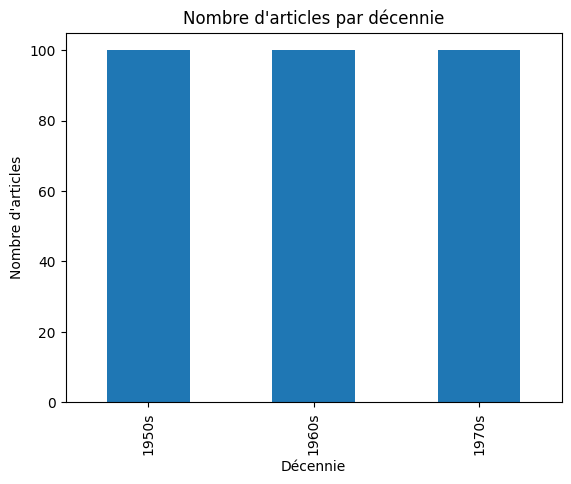


Statistiques word_count :
count       300.000000
mean      36202.276667
std       67424.294070
min         253.000000
25%        9291.000000
50%       21691.000000
75%       39869.250000
max      997600.000000
Name: word_count, dtype: float64


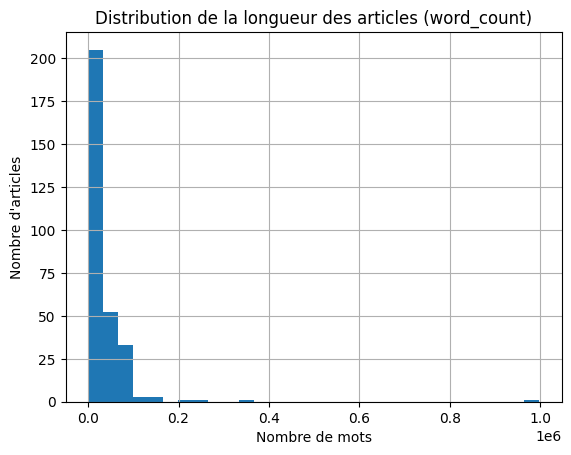

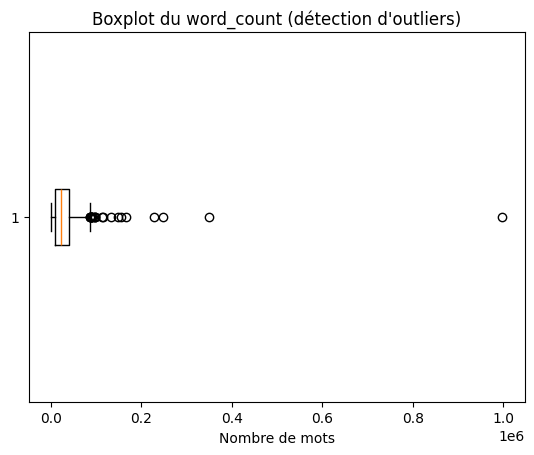

In [13]:
# 5) Statistiques descriptives et premières visualisations
# Objectif : décrire le corpus (répartition temporelle, longueur des textes)
# et repérer d'éventuels outliers (textes très courts ou très longs).

import matplotlib.pyplot as plt

# Répartition par décennie (devrait être équilibrée)
rep_dec = df["decennie"].value_counts().sort_index()
print("Répartition par décennie :")
print(rep_dec)

plt.figure()
rep_dec.plot(kind="bar")
plt.title("Nombre d'articles par décennie")
plt.xlabel("Décennie")
plt.ylabel("Nombre d'articles")
plt.show()

# Statistiques sur la longueur (word_count)
print("\nStatistiques word_count :")
print(df["word_count"].describe())

plt.figure()
df["word_count"].hist(bins=30)
plt.title("Distribution de la longueur des articles (word_count)")
plt.xlabel("Nombre de mots")
plt.ylabel("Nombre d'articles")
plt.show()

# Boxplot pour visualiser les outliers
plt.figure()
plt.boxplot(df["word_count"], vert=False)
plt.title("Boxplot du word_count (détection d'outliers)")
plt.xlabel("Nombre de mots")
plt.show()


Taille originale : 300
Taille après filtrage : 292

Distribution des longueurs :
count       292.000000
mean      29841.006849
std       26786.454185
min        1077.000000
25%        9291.000000
50%       21477.000000
75%       38539.750000
max      148417.000000
Name: word_count, dtype: float64


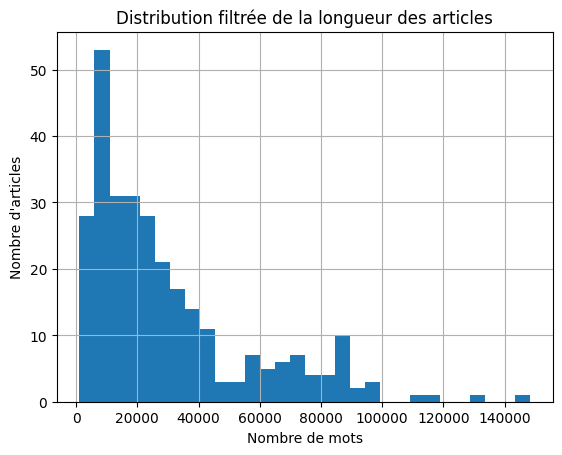

In [14]:
# 6) Filtrage des articles trop courts ou anormalement longs
# Objectif : supprimer les textes aberrants (OCR massifs) et
# éliminer les fragments trop courts pour une analyse fiable.

min_words = 800      # seuil minimum raisonnable
max_words = 150000   # seuil maximum pour éliminer les OCR monstrueux

df_filtre = df[(df["word_count"] >= min_words) & (df["word_count"] <= max_words)].copy()

print("Taille originale :", len(df))
print("Taille après filtrage :", len(df_filtre))
print("\nDistribution des longueurs :")
print(df_filtre["word_count"].describe())

# graphique mis à jour
df_filtre["word_count"].hist(bins=30)
plt.title("Distribution filtrée de la longueur des articles")
plt.xlabel("Nombre de mots")
plt.ylabel("Nombre d'articles")
plt.show()


In [15]:
# 7) Prétraitement linguistique de base (français)
# Objectif : normaliser les textes pour l'analyse quantitative :
# - minuscules
# - suppression de la ponctuation
# - suppression des chiffres isolés
# - suppression des stopwords français

import re
import nltk
from nltk.corpus import stopwords

# Téléchargement des stopwords français (une seule fois)
nltk.download("stopwords")

stopwords_fr = set(stopwords.words("french"))

def nettoyer_texte(texte):
    if not isinstance(texte, str):
        return ""

    # Passage en minuscules
    texte = texte.lower()

    # Suppression des chiffres
    texte = re.sub(r"\d+", " ", texte)

    # Suppression de la ponctuation
    texte = re.sub(r"[^\w\s]", " ", texte)

    # Suppression des espaces multiples
    texte = re.sub(r"\s+", " ", texte).strip()

    # Suppression des stopwords
    tokens = texte.split()
    tokens = [t for t in tokens if t not in stopwords_fr and len(t) > 2]

    return " ".join(tokens)

# Application du nettoyage
df_filtre["texte_nettoye"] = df_filtre["complete_text"].apply(nettoyer_texte)

# Contrôles
print("Exemple de texte original :\n")
print(df_filtre["complete_text"].iloc[0][:500])

print("\nExemple de texte nettoyé :\n")
print(df_filtre["texte_nettoye"].iloc[0][:500])

print("\nLongueur moyenne après nettoyage (en mots) :")
print(df_filtre["texte_nettoye"].apply(lambda x: len(x.split())).mean())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Exemple de texte original :


c jùan&amp; ce numézc : 
EXERCICES DE JOUR ET DE NUIT 
BELGIQUE: 20 F " SUISSE: 2 F " 
 
AVENUE MARCEAU PARIS VIII 
 
COURRIER 
Dans votre numéro 60 du 15 octobre dernier, vous avez consacré, page 23, quelques lignes au Farman F.40. Je me permets de vous signaler que la tusion Henri et Maurice Farman était accomplie avant la guerre de 1914. Le F.40 a été construit par les usines de Billancourt et également à l'annexe de Lyon, au début de 1916, comme vous l'indiquez. Cet avion était un amalgame 

Exemple de texte nettoyé :

jùan amp numézc exercices jour nuit belgique suisse avenue marceau paris viii courrier numéro octobre dernier consacré page quelques lignes farman permets signaler tusion henri maurice farman accomplie avant guerre construit usines billancourt également annexe lyon début comme indiquez cet avion amalgame farman cellule tuselage moteur renault farman dont tenait plan surélevé liaison cellule plan tubes métalliques disposés façon former pi

In [16]:
# 8) Représentation vectorielle des textes : TF-IDF
# Objectif :
# Transformer les textes nettoyés en une matrice document-terme
# pondérée par TF-IDF (Term Frequency – Inverse Document Frequency).
# Cette représentation permet de mettre en valeur les termes
# discriminants et constitue la base du topic modeling et
# des analyses ultérieures.

from sklearn.feature_extraction.text import TfidfVectorizer

# Initialisation du vectoriseur TF-IDF
vectorizer = TfidfVectorizer(
    max_df=0.9,        # exclut les termes trop fréquents (peu discriminants)
    min_df=5,          # exclut les termes trop rares
    max_features=5000  # limite la taille du vocabulaire
)

# Construction de la matrice TF-IDF
X_tfidf = vectorizer.fit_transform(df_filtre["texte_nettoye"])

# Contrôles
print("Dimensions de la matrice TF-IDF (documents × termes) :", X_tfidf.shape)

termes = vectorizer.get_feature_names_out()
print("Nombre de termes retenus :", len(termes))
print("Exemples de termes :", termes[:20])


Dimensions de la matrice TF-IDF (documents × termes) : (292, 5000)
Nombre de termes retenus : 5000
Exemples de termes : ['abandon' 'abandonner' 'abbaye' 'abbé' 'abondance' 'abonnement'
 'abonnements' 'abonnés' 'abord' 'aborder' 'aboutir' 'aboutit' 'abraham'
 'abri' 'abrégé' 'absence' 'absolue' 'absolument' 'absorption' 'académie']


In [17]:
# 9) Topic modeling avec Non-negative Matrix Factorization (NMF)
# Objectif :
# Identifier des thématiques latentes dans le corpus à partir
# de la matrice TF-IDF, en utilisant la factorisation NMF.

from sklearn.decomposition import NMF
import numpy as np

# Nombre de topics
n_topics = 10

# Initialisation du modèle NMF
nmf_model = NMF(
    n_components=n_topics,
    random_state=42,
    init="nndsvd",
    max_iter=500
)

# Apprentissage du modèle
W = nmf_model.fit_transform(X_tfidf)  # documents × topics
H = nmf_model.components_             # topics × termes

print("Dimensions W (documents × topics) :", W.shape)
print("Dimensions H (topics × termes) :", H.shape)

# Affichage des mots-clés pour chaque topic
n_top_words = 12

feature_names = termes

for topic_idx, topic in enumerate(H):
    top_indices = topic.argsort()[:-n_top_words - 1:-1]
    top_terms = [feature_names[i] for i in top_indices]
    print(f"\nTopic {topic_idx + 1} :")
    print(", ".join(top_terms))


Dimensions W (documents × topics) : (292, 10)
Dimensions H (topics × termes) : (10, 5000)

Topic 1 :
sociale, social, vie, formation, politique, aussi, enfants, action, sociales, problèmes, faut, sociaux

Topic 2 :
seine, préfet, municipal, police, art, préfecture, ville, arrondissement, heures, arrêté, publique, conseillers

Topic 3 :
dieu, jésus, christ, salut, vie, bible, homme, armée, monde, major, seigneur, foi

Topic 4 :
sport, pts, ligue, sportive, fédération, club, championnats, fédéral, athlétisme, clubs, jeunes, sports

Topic 5 :
arrêté, décret, algérie, échelon, art, classe, compter, article, portant, décembre, janvier, chef

Topic 6 :
air, avion, aéro, vol, aviation, passagers, club, pilote, appareil, moteur, vitesse, fret

Topic 7 :
siècle, aussi, histoire, peu, société, vers, église, quelques, abbé, orléans, pierre, roi

Topic 8 :
importations, exportations, ffl, produits, production, indice, moy, indices, etranger, total, franc, trim

Topic 9 :
the, and, fig, eau, eaux, 

Exemples de topics dominants :
  decennie  topic_dominant
0    1950s               5
1    1960s               5
2    1950s               3
3    1950s               6
4    1950s               4

Tableau croisé (topics × décennies) :
topic_dominant   0   1   2  3   4   5   6  7   8  9
decennie                                           
1950s            4   8   7  9  23   9  28  2   6  1
1960s           10  27   9  9   8   7  20  4   4  2
1970s           22   0  11  5   1  10  31  3  10  2

Tableau croisé normalisé (proportion par décennie) :
topic_dominant         0         1         2         3         4         5  \
decennie                                                                     
1950s           0.041237  0.082474  0.072165  0.092784  0.237113  0.092784   
1960s           0.100000  0.270000  0.090000  0.090000  0.080000  0.070000   
1970s           0.231579  0.000000  0.115789  0.052632  0.010526  0.105263   

topic_dominant         6         7         8         9  
decenn

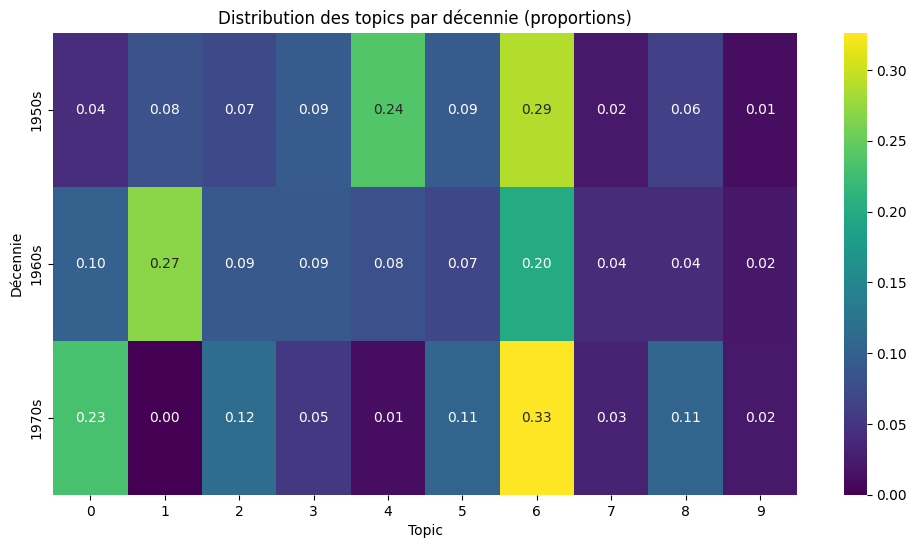

In [18]:
# 10) Attribution du topic dominant et analyse temporelle
# Objectif :
# - Associer à chaque article le topic le plus probable (topic dominant)
#   à partir de la matrice W.
# - Calculer la distribution des topics dans chaque décennie.
# - Visualiser les variations thématiques à l'aide d'une heatmap.

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Attribution du topic dominant pour chaque article
df_filtre["topic_dominant"] = W.argmax(axis=1)

print("Exemples de topics dominants :")
print(df_filtre[["decennie", "topic_dominant"]].head())

# 2) Tableau croisé : distribution (topics × décennies)
table_topics = pd.crosstab(df_filtre["decennie"], df_filtre["topic_dominant"])

print("\nTableau croisé (topics × décennies) :")
print(table_topics)

# Normalisation par ligne (% sur chaque décennie)
table_topics_norm = table_topics.div(table_topics.sum(axis=1), axis=0)

print("\nTableau croisé normalisé (proportion par décennie) :")
print(table_topics_norm)

# 3) Heatmap de la distribution des topics par décennie
plt.figure(figsize=(12, 6))
sns.heatmap(table_topics_norm, annot=True, cmap="viridis", fmt=".2f")
plt.title("Distribution des topics par décennie (proportions)")
plt.xlabel("Topic")
plt.ylabel("Décennie")
plt.show()


In [20]:
# 11) Extraction des mots-clés caractérisant chaque topic
# Objectif :
# - Identifier les 15 termes les plus représentatifs par topic
# - Faciliter l'interprétation qualitative du modèle

n_top_words = 15

print("Mots-clés les plus représentatifs par topic :\n")

for topic_idx, topic in enumerate(H):
    top_indices = topic.argsort()[-n_top_words:][::-1]
    top_terms = [feature_names[i] for i in top_indices]
    print(f"Topic {topic_idx+1} : {', '.join(top_terms)}\n")


Mots-clés les plus représentatifs par topic :

Topic 1 : sociale, social, vie, formation, politique, aussi, enfants, action, sociales, problèmes, faut, sociaux, travailleurs, congrès, donc

Topic 2 : seine, préfet, municipal, police, art, préfecture, ville, arrondissement, heures, arrêté, publique, conseillers, question, mairie, personnel

Topic 3 : dieu, jésus, christ, salut, vie, bible, homme, armée, monde, major, seigneur, foi, père, dimanche, amour

Topic 4 : sport, pts, ligue, sportive, fédération, club, championnats, fédéral, athlétisme, clubs, jeunes, sports, bat, commission, basket

Topic 5 : arrêté, décret, algérie, échelon, art, classe, compter, article, portant, décembre, janvier, chef, loi, mer, fixant

Topic 6 : air, avion, aéro, vol, aviation, passagers, club, pilote, appareil, moteur, vitesse, fret, aéronautique, compagnies, compagnie

Topic 7 : siècle, aussi, histoire, peu, société, vers, église, quelques, abbé, orléans, pierre, roi, rabelais, lille, mme

Topic 8 : impo

In [21]:
# 12) Conclusion quantitative et sauvegarde des résultats
# Objectif :
# - Résumer les principaux résultats quantitatifs
# - Sauvegarder le corpus enrichi (topics, décennie, texte nettoyé)

# Résumé quantitatif
print("Résumé du corpus final :")
print("Nombre total d'articles :", len(df_filtre))
print("Décennies étudiées :", df_filtre['decennie'].unique())
print("Nombre de topics :", n_topics)

print("\nDistribution globale des topics :")
print(df_filtre["topic_dominant"].value_counts().sort_index())

# Sauvegarde du corpus enrichi
colonnes_a_sauver = [
    "file_id",
    "title",
    "date",
    "annee",
    "decennie",
    "author",
    "word_count",
    "topic_dominant",
    "texte_nettoye"
]

fichier_sortie = "corpus_presse_fr_topics_1950s_1960s_1970s.csv"
df_filtre[colonnes_a_sauver].to_csv(fichier_sortie, index=False)

print("\nFichier sauvegardé :", fichier_sortie)


Résumé du corpus final :
Nombre total d'articles : 292
Décennies étudiées : ['1950s' '1960s' '1970s']
Nombre de topics : 10

Distribution globale des topics :
topic_dominant
0    36
1    35
2    27
3    23
4    32
5    26
6    79
7     9
8    20
9     5
Name: count, dtype: int64

Fichier sauvegardé : corpus_presse_fr_topics_1950s_1960s_1970s.csv
